# CIFAR -10 accuracy test

# Library

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset 
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader
import numpy as np

from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


# Hyper parameter setting

In [0]:
learning_rate = 1e-3
epochs = 100
display_step = 10
batch_size = 32

activation = nn.ReLU()
max_pool = nn.MaxPool2d(2,2)

# Load data & Pre-process data

Files already downloaded and verified
Files already downloaded and verified
len(train_data):  50000
len(test_data):  10000
data tensor([[[-2.4291, -2.4183, -2.2214],
         [-2.4291, -2.4183, -2.2214],
         [-2.4291, -2.4183, -2.2214],
         ...,
         [-0.1610, -0.9629, -1.5385],
         [-0.1998, -1.0416, -1.5776],
         [-0.3743, -1.1792, -1.6751]],

        [[-2.4291, -2.4183, -2.2214],
         [-2.4291, -2.4183, -2.2214],
         [-2.4291, -2.4183, -2.2214],
         ...,
         [-0.0835, -0.9039, -1.5190],
         [-0.0253, -0.9039, -1.5190],
         [ 0.0328, -0.8646, -1.4605]],

        [[-2.4291, -2.4183, -2.2214],
         [-2.4291, -2.4183, -2.2214],
         [-2.4291, -2.4183, -2.2214],
         ...,
         [ 0.1104, -0.7662, -1.4020],
         [ 0.2073, -0.6876, -1.3434],
         [ 0.0716, -0.8056, -1.4800]],

        ...,

        [[-2.4291, -2.4183, -2.2214],
         [-2.4291, -2.4183, -2.2214],
         [-2.4291, -2.4183, -2.2214],
         ...

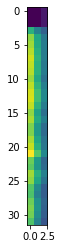

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


data shape: torch.Size([32, 3, 32, 32])
label: tensor([6, 1, 1, 9, 4, 2, 2, 8, 5, 1, 8, 1, 5, 9, 5, 9, 4, 0, 4, 1, 6, 6, 5, 4,
        0, 5, 1, 9, 6, 4, 0, 8])


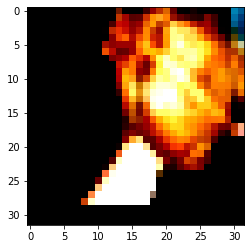

In [0]:
# load data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_data = dataset.CIFAR10("./", train = True, transform = transform_train, target_transform = None, download = True)
test_data = dataset.CIFAR10("./", train = False, transform = transform_test, target_transform = None, download = True)
# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
x_train = np.transpose(x_train, (1,2,0))
# 3 x 32 x 32에서 32 x 32 x 3으로 변환

print('data', x_train)
print('data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(np.transpose(example_data[0], (1,2,0)))
plt.show()

# Model & Optimization and Loss function

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() 
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.BatchNorm2d(64),
            activation,
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            activation,
            max_pool,
            nn.Dropout(0.3),
            
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            activation,
            max_pool,
            nn.Dropout(0.3),

            nn.Conv2d(256, 512, 3),
            nn.BatchNorm2d(512),
            activation,
            max_pool,
            nn.Dropout(0.2)

        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 256),
            nn.BatchNorm1d(256),
            activation,
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            activation,
            nn.Dropout(0.2),
            nn.Linear(128, 10)
            
        )
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # [32, 256, 6, 6]
        flatten = extracted_feature.view(batch_size, -1) # [32, 256 * 6 * 6]
        result = self.classifier(flatten)
        return result
    

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
        
model = CNN()
model.apply(init_weights)
model.to(device)
model.train()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


# Train & Test

In [0]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())

60 epoch loss: 0.4304533004760742
70 epoch loss: 0.2155846804380417
80 epoch loss: 0.1945393681526184
90 epoch loss: 0.2991451621055603


In [0]:
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("CIFAR10 test_accuracy : {}".format(correct/total))

CIFAR10 test_accuracy : 0.9108573794364929
